# Predicting Car Prices using KNN

In this project, we will use the K-nearest neighbors algorithm to predict car's market price using its attributes. The data set we will be working with contains information on various cars, and its documentation can be found [here](https://archive.ics.uci.edu/ml/datasets/automobile).

### Introduction
#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

#### Reading and previewing the dataset

In [2]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 
        'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)

cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


### Data Preparation

#### Trimming dataset to only numeric columns
First of all, we are going to make a trimmed copy of the dataset containing only the columns with continuous numeric values, that can later be used as features of our model.

In [3]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 
                          'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 
                          'city-mpg', 'highway-mpg', 'price']

numeric_cars = cars[continuous_values_cols]

numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


#### Replacing  '?' for NaN values

We usually can't have any missing values if we want to use them for predictive modeling. Based on the data set preview from the last step, we can tell that the `normalized-losses` column contains missing values represented using "?", so we will replace them for NaN values.

In [4]:
numeric_cars = numeric_cars.replace('?', np.nan)
numeric_cars = numeric_cars.astype(float)
numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,NaN,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,NaN,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


#### Dealing with NaN values

In [5]:
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

Because there are 41 NaN values at the `normalized-losses` column, which is close to 20% of the entire dataset, we will drop this column entirely. We will also drop every row that contains NaN price values, since this is the column we want to predict.

In [6]:
numeric_cars = numeric_cars.drop('normalized-losses', axis=1)
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.isnull().sum()

wheel-base          0
length              0
width               0
height              0
curb-weight         0
engine-size         0
bore                4
stroke              4
compression-rate    0
horsepower          2
peak-rpm            2
city-mpg            0
highway-mpg         0
price               0
dtype: int64

In [7]:
numeric_cars.isna().sum(axis=1).sort_values(ascending=False).head(10)

55     2
56     2
57     2
58     2
130    2
131    2
204    0
68     0
74     0
73     0
dtype: int64

For the other columns, we can see that the maximum number of NaN values is 4, less than 2% of the total data. In adition to this, the biggest number of NaN values in a single row in 2, this happening in 6 different rows. Because of these observations, we will replace all NaN values for the mean of the column, as we would be losing relevant data by dropping the column or the row with the NaN value.

In [8]:
numeric_cars = numeric_cars.fillna(numeric_cars.mean())
numeric_cars.isnull().sum()

wheel-base          0
length              0
width               0
height              0
curb-weight         0
engine-size         0
bore                0
stroke              0
compression-rate    0
horsepower          0
peak-rpm            0
city-mpg            0
highway-mpg         0
price               0
dtype: int64

#### Data Randomization and Normalization

Randomizing the dataset and then normalizing all columns, except the target column, to the standard normal distribution (mean of 0, standard deviation of 1), to prevent any single column from having too much of an impact on the distance.

In [9]:
# Randomization
np.random.seed(1)
shuffled_index = np.random.permutation(numeric_cars.index)
numeric_cars = numeric_cars.reindex(shuffled_index)

# Normalization and Creation of price_col and train_cols
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col
    
train_cols = numeric_cars.drop('price', axis=1).copy()

### Modeling

The metric used to calculate the distance between observations is the Standard Euclidean. The validation process used is the K-fold Cross Validation Method, with 5 folds.

In [10]:
# STANDARD MODEL
# Multivariate Model - all features
# Nearest Neighbours K = 5
# K-Fold Cross Validation K = 5

knn = KNeighborsRegressor()
cv = cross_validate(knn, train_cols, price_col, cv=5, scoring = 'neg_mean_squared_error')
rmse_all = np.sqrt(-cv['test_score'])
rmse = rmse_all.mean()
rmse

4955.1919542532805

In [11]:
# FIRST MODEL
# Univariate Model - testing all features individually
# Nearest Neighbours K = 5
# K-Fold Cross Validation K = 5
# Objective: start to analyze how good of a feature each column is.

results_1 = {}

for col in train_cols:
    knn = KNeighborsRegressor()
    cv = cross_validate(knn, train_cols[[col]], price_col, cv=5, scoring = 'neg_mean_squared_error')
    rmse_all = np.sqrt(-cv['test_score'])
    rmse = rmse_all.mean()
    results_1[col] = rmse
    
results_series_1 = pd.Series(results_1).sort_values()
results_series_1

engine-size         4423.967106
horsepower          4479.306124
highway-mpg         4875.444934
city-mpg            4972.802501
curb-weight         5127.589070
width               5858.022667
compression-rate    6817.553416
length              7378.586292
wheel-base          8027.640700
bore                8791.497416
stroke              9301.386592
peak-rpm            9462.456876
height              9481.143489
dtype: float64

In [12]:
# SECOND MODEL
# Univariate Model - testing all features individually
# Nearest Neighbours - testing all odd numbers from 1 to 15
# K-Fold Cross Validation K = 5
# Objective: continue to analyze how good of a feature each column is.

n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]

results_2 = {}
mean_results_2 = {}

for col in train_cols:
    results_col = {}
    col_values = []
    for n in n_neighbors:
        knn = KNeighborsRegressor(n_neighbors=n)
        cv = cross_validate(knn, train_cols[[col]], price_col, cv=5, scoring = 'neg_mean_squared_error')
        rmse_all = np.sqrt(-cv['test_score'])
        rmse = rmse_all.mean()
        results_col[n] = rmse
        col_values.append(rmse)
    mean_results_2[col] = np.mean(col_values)
    results_2[col] = results_col
    
results_series_2 = pd.Series(results_2)
mean_results_series_2 = pd.Series(mean_results_2).sort_values()
mean_results_series_2

engine-size         4609.589907
horsepower          4692.744319
highway-mpg         5124.001338
city-mpg            5190.532603
curb-weight         5363.915610
width               5936.412019
length              7058.212011
compression-rate    7371.232748
wheel-base          7671.162111
bore                8669.747703
stroke              8973.136854
peak-rpm            9417.522312
height              9521.362608
dtype: float64

With the mean results, we get a more solid idea of how each column perform as a feature.  The graph below shows how they performed for each K number of neighbors tested out. 

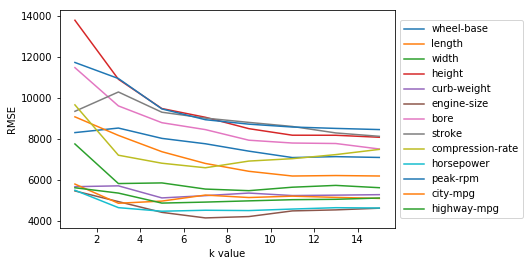

In [13]:
%matplotlib inline

for k,v in results_series_2.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
    plt.legend(train_cols, loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.title('')

In [14]:
# THIRD MODEL
# Multivariate Model - testing all number of X best features
# Nearest Neighbours K = 5
# K-Fold Cross Validation K = 5
# Objective: begin to determine how many and which features to use in our multivariate model in order to get the lowest RMSE.

results_index = mean_results_series_2.index

results_3 = {}

for n in range(1, 14):
    features = []
    for i in range(0, n):
        col = results_index[i]
        features.append(col)    
    knn = KNeighborsRegressor()
    cv = cross_validate(knn, train_cols[features], price_col, cv=5, scoring = 'neg_mean_squared_error')
    rmse_all = np.sqrt(-cv['test_score'])
    rmse = rmse_all.mean()
    results_3['{} best features'.format(n)] = rmse
    
results_series_3 = pd.Series(results_3).sort_values()
results_series_3

4 best features     3512.117865
3 best features     3586.950528
2 best features     3691.435885
6 best features     4011.336440
7 best features     4178.221121
5 best features     4412.416809
1 best features     4423.967106
8 best features     4690.721012
9 best features     4767.223058
10 best features    4888.522739
13 best features    4951.628875
12 best features    4974.465339
11 best features    4997.988714
dtype: float64

#### Important observations so far

Interpreting the results from the second and third model.

From the second model, we can see that, although the `curb-weight` variable has similar RMSE mean results in comparison to both `highway-mpg` and `city-mpg` variables, it's curve on the graph is less smoother at the beginning and there isn't a single K value in which the `curb-weight` RMSE is lower than the top 4.
In addition to this, from the second model, we have the information that using the 2, 3 or 4 best features has very similar RMSE values, those being way lower RMSE than using 5 or more.

Based on these observations, although using the 4 best features granted us the best results in the Third Model, if we test every combination of the 4 best features, we may find an even better combination.

In [15]:
# FOURTH MODEL
# Multivariate Model - testing all combinations of the 4 best features
# Nearest Neighbours - testing all odd numbers from 1 to 15
# K-Fold Cross Validation K = 5
# Objective: continue to determine how many features to use in our multivariate model in order to get the lowest RMSE.

b_f = results_index[0:4] #b_f are the four best features (engine-size, horsepower, highway-mpg and city-mpg) in terms of RMSE

results_4 = {}

for uno in range(0, 4): #number of features
    for dos in range(0, 4):
        for tres in range(0, 4):
            for cuatro in range(0, 4):
                c = b_f[[uno, dos, tres, cuatro]]
                knn = KNeighborsRegressor()
                cv = cross_validate(knn, train_cols[c], price_col, cv=5, scoring = 'neg_mean_squared_error')
                rmse_all = np.sqrt(-cv['test_score'])
                rmse = rmse_all.mean()
                results_4[str(c)] = rmse

results_series_4 = pd.Series(results_4).sort_values()
results_series_4.head()

Index(['horsepower', 'city-mpg', 'engine-size', 'engine-size'], dtype='object')    3130.508132
Index(['horsepower', 'engine-size', 'engine-size', 'city-mpg'], dtype='object')    3130.508132
Index(['horsepower', 'engine-size', 'city-mpg', 'engine-size'], dtype='object')    3130.508132
Index(['engine-size', 'city-mpg', 'horsepower', 'engine-size'], dtype='object')    3140.941473
Index(['engine-size', 'city-mpg', 'engine-size', 'horsepower'], dtype='object')    3140.941473
dtype: float64

From the Fourth Model, we can see that actually, the best combination of the 4 best features in terms of RMSE is `engine-size`, `horsepower` and `city-mpg`, that are the first, second and forth best features individually from the second model.

In [16]:
# FIFTH MODEL
# Multivariate Model - using engine-size, horsepower and city-mpg
# Nearest Neighbours - testing all odd numbers from 1 to 15
# K-Fold Cross Validation K = 5
# Objective: test the final model.

results_5 = {}

for n in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=n)
    cv = cross_validate(knn, train_cols[['engine-size','horsepower','city-mpg']], price_col, cv=5, scoring = 'neg_mean_squared_error')
    rmse_all = np.sqrt(-cv['test_score'])
    rmse = rmse_all.mean()
    results_5['K Value of {}'.format(n)] = rmse

results_5

{'K Value of 1': 4019.778788490677,
 'K Value of 3': 3072.521999831769,
 'K Value of 5': 3230.195815801379,
 'K Value of 7': 3601.8655365366058,
 'K Value of 9': 3948.129870256506,
 'K Value of 11': 4150.723997239938,
 'K Value of 13': 4291.885150962573,
 'K Value of 15': 4338.4775103691245}

### Conclusions

With this analysis, by using the K-fold Cross Validation method with 5 folds, we conclude that the best K Nearest Neighbors Regressor model to use takes into consideration 3 neighbors and utilizes the `engine-size`, `horsepower` and `city-mpg` columns as features. The best obtained RMSE is 3072.53, that is 38% lower than the standard KNN scikit-learn model results, and 30.55% lower than the best univariate KNN model using the standard number of neighbors (K=5).


### Next steps

Because of how small our dataset is, redoing this analysis utilizing the LOOCV (Leave One Out Cross Validation) method may be a good option, to get an even better grasp of what are the best parameters for our model. Also, there is a lot of room for improvement on the Fourth Model code.

